In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from astropy.io import fits

# Structure to store the outputs of fiber assignement

This notebook follows the documentation in DocDB-1049.

The principal outputs of Fiber Allocations are
- FiberMap. A pointing defining which targets are on which fiber.
- PotentialFiberMap. The set of targets that can be reached by a set of bers in a tile.
The previous two sets will be stored in the same FITS file for each tile and
pointing. This means that two different assignment algorithms running on the
same tile producing different pointings will store the results in different files.

FiberMap is a table with the following columns.
- `fiber`: [0-4999]
- `positioner`: [0-4999]
- `numtarget`: [0-] Number of potential target IDs associated to each fiber.
- `objtype`: ELG, LRG, QSO, SKY, STDSTAR, GAL, OTHER.
- `targetid`: unique target identifier to get back to target selection info. Corresponds to the cand ID in the TargetDB.
- `desi_target0`: 64 bit mask of targeting info.
- `ra`: degrees [0-360].
- `dec`: degrees [-90 - +90].
- `xfocal_design`: mm from center in positioner coordinate system 
- `yfocal_design`: mm from center in positioner coordinate system

PotentialFiberMap is a table with only one column.

- `potentialtargetid`: unique target identifier to get back to target selection info. This contains all the targets that can be reached by a fiber. Corresponds to the cand ID in the TargetDB. This concatenates the sets of available targets for each fiber.

#Example on poissonian targets

## Load the fibers

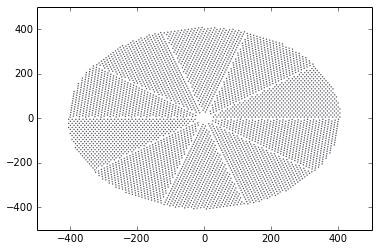

In [75]:
positioner_file = "../../surveyplan/data/pos_on_z1.txt"
positioner_data = loadtxt(positioner_file)
x_pos = positioner_data[:,1]
y_pos = positioner_data[:,2]
z_pos = positioner_data[:,3]
scatter(x_pos, y_pos, s=0.1)
n_pos = size(x_pos)

patrol_radius = 6.0
inner_radius = 5.0 
fiber_radius = 1.0

## Create random set of targets

IndexError: index 0 is out of bounds for axis 0 with size 0

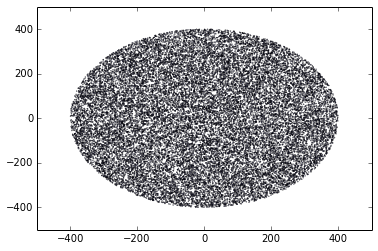

In [78]:
n_targets = n_pos * 5
target_id = arange(n_targets)
theta_rand = 2.0*pi*random.random(n_targets)
r_rand = 160000.0*random.random(n_targets)
x_target = sqrt(r_rand) * sin(theta_rand)
y_target = sqrt(r_rand) * cos(theta_rand)
ra = random.random(n_targets)*1.8
dec = random.random(n_targets)*1.2

scatter(x_target, y_target, s=0.1)

possible_types = ['ELG', 'LRG', 'QSO', 'STDSTAR', 'GAL', 'OTHER']
types = empty((0))
for i in range(n_targets):
    types[i] = random.choice(possible_types)

## Run the simplest fiber assignment

In [77]:
x_on_target = zeros(n_pos)
y_on_target = zeros(n_pos)
ra_target = zeros(n_pos)
dec_target = zeros(n_pos)
num_targets = zeros(n_pos, dtype='int')
assigned_target = zeros(n_pos, dtype='int')

target_available = zeros(n_targets) #bookkeeping variable, tells me if target is already assigned

all_available_targets = empty((0))

#loop on the positioners
for i in range(n_pos):
    x_pos_i = x_pos[i]
    y_pos_i = y_pos[i]
    
    distance = sqrt((x_target-x_pos_i)**2 + (y_target - y_pos_i)**2)
    
    # I get all possible targets within the reach of this positioner
    available = where(distance<patrol_radius) 
    # to append them in a single array listng all the possible targets
    all_available_targets = append(all_available_targets, available)
    # counting how many of those I have in each positioner..
    num_targets[i] = size(available[0])

    # Here I get the list of possible targets discarding those already assigned
    reachable = where((distance<patrol_radius)&(target_available==0)) 
    reachable = reachable[0]
    n_reachable = size(reachable)
    
    if (n_reachable):
        x_on_target[i] = x_target[reachable[0]]
        y_on_target[i] = y_target[reachable[0]]
        target_available[reachable[0]] = -1
        assigned_target[i] = target_id[reachable[0]]
        type_target = append(type_target, random.choice(types))
        ra_target = ra[reachable[0]]
        dec_target = dec[reachable[0]]
    else:
        x_on_target[i] = x_pos_i
        y_on_target[i] = y_pos_i
        assigned_target[i] = -1 
        type_target = append(type_target, 'SKY')

IndexError: index 26087 is out of bounds for axis 0 with size 25000

In [65]:
print num_targets, cumsum(num_targets)
print size(all_available_targets)
print type_target

[ 6 10  3 ...,  0  0  0] [    6    16    19 ..., 29920 29920 29920]
29920
['STDSTAR' 'LRG' 'STDSTAR' ..., 'SKY' 'SKY' 'SKY']


In [8]:
print first_available_gal

[    0     7     9 ..., 47816 47822 47829]


In [9]:
#!rm fiber_allocation.fits
#fits.append("fiber_allocation.fits", galaxies_id) # galaxy Id
#fits.append("fiber_allocation.fits", fibers_id) # fiber Id
#fits.append("fiber_allocation.fits", flat_galaxies_in_fiber) # full list of all galaxies reached by each fiber
#fits.append("fiber_allocation.fits", n_available_gal) # number of available galaxies per fiber
#fits.append("fiber_allocation.fits", first_available_gal) # index in the array flat_galaxies_in_fiber

In [10]:
#hdulist = fits.open("fiber_allocation.fits")
#print hdulist.info()

In [72]:
!rm table.fits
c1=fits.Column(name='TARGETID',format='I',array=galaxies_id)
c2=fits.Column(name='RA',format='D',array=ra)
c3=fits.Column(name='DEC', format='D', array=dec)
c4=fits.Column(name='OBJTYPE', format='8A', array=type_target)

cs=fits.ColDefs([c1,c2,c3,c4])
table_hdu=fits.TableHDU.from_columns(cs)
hdu=fits.PrimaryHDU()
hdulist=fits.HDUList([hdu])
hdulist.append(table_hdu)
hdulist.verify()
hdulist.writeto("table.fits")
#>>> c2=pyfits.Column(name=’RA’,format=’D’,array=inp2
#)
#>>> c3=pyfits.Column(name=’DEC’,format=’D’,array=inp3)
#>>> c4=pyfits.Column(name=’V’,format=’E’,array=inp

In [71]:
hdu=fits.open("table.fits")
hdu.info()

Filename: table.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                TableHDU        20   25000R x 4C   [I10, D25.17, D25.17, A8]   
